In [20]:
import pandas as pd
import numpy as np
import sklearn
import pyreadr

#statistics
from scipy.stats import chi2_contingency, ttest_ind

# import cudf #gpu-powered DataFrame (Pandas alternative)

# #imbalance handling
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler, RepeatedEditedNearestNeighbours
# from imblearn.pipeline import Pipeline

#preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler


#internal validation
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedStratifiedKFold, cross_val_score, GridSearchCV, PredefinedSplit, train_test_split

#performance metrices
from sklearn.metrics import confusion_matrix, classification_report, f1_score, balanced_accuracy_score, matthews_corrcoef, auc, average_precision_score, roc_auc_score, balanced_accuracy_score, roc_curve, accuracy_score
from sklearn.metrics import log_loss
#Models selection
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
# from cuml.svm import SVC #gpu-powered SVM

from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
#for model calibration:
from sklearn.calibration import CalibratedClassifierCV
import ml_insights as mli

#Tree pruning
from sklearn.tree._tree import TREE_LEAF

import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional, Input, concatenate, Reshape, Activation, Flatten, Add, BatchNormalization, Multiply, LeakyReLU
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.metrics import AUC, SensitivityAtSpecificity
from tensorflow.keras.optimizers import Adam, Adagrad, RMSprop, Adamax, SGD, Adadelta
from tensorflow.keras.initializers import Constant
from tensorflow.keras.regularizers import L1L2, L1, L2


#save and load trained model
import pickle

#visualisation
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from sklearn import tree

from collections import Counter
import os

In [21]:
# Data loader
# features = pd.read_csv("../FinalData/cleaned_features_11072023.csv")
gridSearchData, crossValData, internalEvaluationData, externalEvaluationData = pickle.load(open('../../Clean_data/dataset_scaled_ordinal.sav', 'rb'))
outcomes = pd.read_csv("../../Clean_data/cleaned_outcomes_24062025.csv")
# features = features[features.columns[1:]]
# outcomes = outcomes[outcomes.columns[1:]]

In [22]:
#Define feature candidates

features_columns = gridSearchData.columns.to_list()
exclude_columns = ['patid', 'practice_id', 'set', #identifier
                   'BMI', #use the categorical instead
                   'ethnicity', #use ethnic_group instead
                   'Spacer',  #all zero
                   'asthmaPlan', #use the continuous one
                   
                   'outcome_3months', 'outcome_6months', 'outcome_9months', 'outcome_12months', 'outcome_15months', 'outcome_18months', 
                   'outcome_21months', 'outcome_24months', 'outcome_combined_6months', 'outcome_combined_9months', 'outcome_combined_12months', 
                   'outcome_combined_15months', 'outcome_combined_18months', 'outcome_combined_24months', '3months', '6months', '12months', '24months', #outcomes variable
                   
                   'postcode_district', 'County', 'LocalAuthority', 'OutputAreaClassification', #location related variables, use IMD decile only
                   
                   'age_cat', 'ICS_medication_possesion_ratio_cat', 'numOCS_cat', 'numOCSEvents_cat', 'numOCSwithLRTI_cat', 'numAcuteRespEvents_cat', 
                   'numAntibioticsEvents_cat', 'numAntibioticswithLRTI_cat', 'numAsthmaAttacks_cat', 'numHospEvents_cat', 'numPCS_cat', 'numPCSAsthma_cat', 
                   'numAsthmaManagement_cat', 'numAsthmaReview_cat', 'numAsthmaMedReview_cat', 'numAsthmaReviewRCP_cat', 'average_daily_dose_ICS_cat', 
                   'prescribed_daily_dose_ICS_cat', #use continous vars instead
                   
                   'count_rhinitis', 'count_cardiovascular', 'count_heartfailure',
                   'count_psoriasis', 'count_anaphylaxis', 'count_diabetes', 'count_ihd',
                   'count_anxiety', 'count_eczema', 'count_nasalpolyps',
                   'count_paracetamol', 'count_nsaids', 'count_betablocker', #use binary ones
                   
                   'paracetamol', 'nsaids', 'betablocker', #no data in evaluation
                   'numAsthmaMedReview', 'numAsthmaReviewRCP',
                                      
                  ]
# exclude_columns = exclude_columns + [x for x in features_columns if '_count' in x] #filter out commorbid count variables
features_columns = [x for x in features_columns if x not in exclude_columns]
print('Features size: ', len(features_columns))
print(features_columns)

Features size:  48
['sex', 'rhinitis', 'cardiovascular', 'heartfailure', 'psoriasis', 'anaphylaxis', 'diabetes', 'ihd', 'anxiety', 'eczema', 'nasalpolyps', 'ethnic_group_Asian', 'ethnic_group_Black', 'ethnic_group_Mixed', 'ethnic_group_Other', 'ethnic_group_White', 'ethnic_group_not recorded', 'smokingStatus_current', 'smokingStatus_former', 'smokingStatus_never', 'DeviceType_BAI', 'DeviceType_DPI', 'DeviceType_NEB', 'DeviceType_not recorded', 'DeviceType_pMDI', 'PriorEducation_No', 'PriorEducation_Yes', 'age', 'average_daily_dose_ICS', 'prescribed_daily_dose_ICS', 'ICS_medication_possesion_ratio', 'numPCS', 'numPCSAsthma', 'numAntibioticsEvents', 'numAntibioticswithLRTI', 'numOCSEvents', 'numOCSwithLRTI', 'numAsthmaAttacks', 'numAcuteRespEvents', 'numHospEvents', 'numAsthmaManagement', 'numAsthmaReview', 'imd_decile', 'CharlsonScore', 'BTS_step', 'BMI_cat', 'PEFStatus', 'EosinophilLevel']


In [23]:
X = crossValData[features_columns]
X_gridSearch = gridSearchData[features_columns]
X = pd.concat([X, X_gridSearch])
X.reset_index(drop=True, inplace=True)
X_internalVal = internalEvaluationData[features_columns]
X_externalVal = externalEvaluationData[features_columns]


print(X.shape)
print(X_internalVal.shape)
print(X_externalVal.shape)


target_outcomes = [
    'outcome_3months', 'outcome_6months', 'outcome_9months', 
    'outcome_12months',
] 
# target_outcomes = ['12months'] 
model_names = [
    'LR', 
    'DT', 'RF', 
    'XGB'
              ]

(474188, 48)
(121714, 48)
(19860, 48)


In [24]:
target_outcome = 'outcome_12months'
y = crossValData[target_outcome]
y_gridSearch = gridSearchData[target_outcome]
y = pd.concat([y, y_gridSearch])
y.reset_index(drop=True, inplace=True)
y_internalVal = internalEvaluationData[target_outcome]
y_externalVal = externalEvaluationData[target_outcome]

# Experiment

In [ ]:
model_names = ['LR', 'DT', 'RF', 'XGB']
for model_name in model_names:
    model = pickle.load(open('../MODELS/TestResult/outcome_12months_'+model_name+'.sav', 'rb'))
    preds = model.predict_proba(X_externalVal)
    preds = [x[1] for x in preds]
    fpr, tpr, thresholds = roc_curve(y_externalVal, preds, pos_label=1)
    auc = np.round(roc_auc_score(y_externalVal, preds), 4)
    plt.plot(fpr,tpr,label=model_name+", auc="+str(auc))

plt.legend(loc=4)
plt.show()

In [ ]:
preds = model.predict_proba(X)[:,1]

# Fit Isotonic Regression
iso = IsotonicRegression()
iso.fit(preds, y)

# Fit Platt scaling (logistic calibration)
lr = LogisticRegression(C=99999999999)
lr.fit(preds.reshape(-1,1), y)

#spline
calib = mli.SplineCalib()
calib.fit(preds, y)

In [ ]:
tvec = np.linspace(0,1,1001)
preds_externalVal = model.predict_proba(X_externalVal)[:,1]
iso_probs = iso.predict(tvec)
platt_probs = lr.predict_proba(tvec.reshape(-1,1))[:,1]
splinecalib_probs = calib.calibrate(tvec)
mli.plot_reliability_diagram(y_externalVal, preds_externalVal, error_bars=False);
plt.plot(tvec, splinecalib_probs, label='SplineCalib')
plt.plot(tvec, iso_probs, label='Isotonic')
plt.plot(tvec, platt_probs, label='Platt')
plt.legend()
plt.title('Calibration Curves for different methods');

# START HERE

In [9]:
def calibration_error(true_labels, samples, M):
    # uniform binning approach with M number of bins
    bin_boundaries = np.linspace(0, 1, M + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    # get max probability per sample i
    confidences = np.max(samples, axis=1)
    # get predictions from confidences (positional in this case)
    predicted_label = np.argmax(samples, axis=1)

    # get a boolean list of correct/false predictions
    accuracies = predicted_label==true_labels

    ece = np.zeros(1)
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # determine if sample is in bin m (between bin lower & upper)
        in_bin = np.logical_and(confidences > bin_lower.item(), confidences <= bin_upper.item())
        # can calculate the empirical probability of a sample falling into bin m: (|Bm|/n)
        prob_in_bin = in_bin.mean()

        if prob_in_bin.item() > 0:
            # get the accuracy of bin m: acc(Bm)
            accuracy_in_bin = accuracies[in_bin].mean()
            # get the average confidence of bin m: conf(Bm)
            avg_confidence_in_bin = confidences[in_bin].mean()
            # calculate |acc(Bm) - conf(Bm)| * (|Bm|/n) for bin m and add to the total ECE
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prob_in_bin
    return ece[0]

In [9]:


result = []
model_names = ['LR', 'DT', 'RF', 'XGB', 'LSTM']
for model_name in model_names:
    print(model_name)
    model = pickle.load(open('../MODELS/TestResult/outcome_12months_'+model_name+'.sav', 'rb'))
    preds = model.predict_proba(X_gridSearch)[:,1]
    
    print('calibration method fit')
    sigm_clf = CalibratedClassifierCV(model, cv="prefit", method='sigmoid')
    sigm_clf.fit(X_gridSearch, y_gridSearch)
    iso_clf = CalibratedClassifierCV(model, cv="prefit", method='isotonic')
    iso_clf.fit(X_gridSearch, y_gridSearch)
    calib = mli.SplineCalib()
    calib.fit(preds, y_gridSearch)

    print('calibrated pred on eval')
    preds_eval = model.predict_proba(X_externalVal)[:,1] #uncalibrated
    preds_sigm = sigm_clf.predict_proba(X_externalVal)[:,1] #sigmoid
    preds_iso = iso_clf.predict_proba(X_externalVal)[:,1] #isotonic
    preds_spline = calib.predict_proba(preds_eval) #spline
    preds_naive = [.5] * y_externalVal.shape[0]
    
    
    print('calculate log loss')
    naive_loss = log_loss(y_externalVal, preds_naive)
    uncalib_loss = log_loss(y_externalVal, preds_eval)
    sigm_loss = log_loss(y_externalVal, preds_sigm)
    iso_loss = log_loss(y_externalVal, preds_iso)
    spline_loss = log_loss(y_externalVal, preds_spline)
    
    print('calculate ECE')
    nbins = 10
    naive_ECE = calibration_error(y_externalVal,[[.5, 0.5]] * y_externalVal.shape[0], nbins)
    uncalib_ECE = calibration_error(y_externalVal, model.predict_proba(X_externalVal), nbins)
    sigm_ECE = calibration_error(y_externalVal,sigm_clf.predict_proba(X_externalVal), nbins)
    iso_ECE = calibration_error(y_externalVal,iso_clf.predict_proba(X_externalVal), nbins)
    spline_ECE = calibration_error(y_externalVal,np.concatenate((1-calib.predict(preds_eval).reshape(-1,1),calib.predict(preds_eval).reshape(-1,1)),axis=1), nbins)

    
    temp = [model_name, naive_loss, uncalib_loss, sigm_loss, iso_loss, spline_loss, 
            naive_ECE, uncalib_ECE, sigm_ECE, iso_ECE, spline_ECE
           ]
    result.append(temp)

#     print('Naive loss = {}'.format(np.round(naive_loss,5)))
#     print('Uncalibrated loss = {}'.format(np.round(uncalib_loss,5)))
#     print('Sigmoid loss = {}'.format(np.round(sigm_loss,5)))
#     print('Isotonic loss = {}'.format(np.round(iso_loss,5)))
#     print('Spline loss = {}'.format(np.round(spline_loss,5)))

LR
calibration method fit
calibrated pred on eval
calculate log loss
calculate ECE
DT
calibration method fit
calibrated pred on eval
calculate log loss
calculate ECE
RF
calibration method fit
calibrated pred on eval
calculate log loss
calculate ECE
XGB
[16:00:09] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 3
[16:00:09] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:822: [GPU Hist]: Configure
calibration method fit
calibrated pred on eval
calculate log loss
calculate ECE


In [17]:


result = []
model_names = ['LSTM']
for model_name in model_names:
    _, _, _, externalEvaluation_X, _, _, _, externalEvaluation_tab, _, _, _, externalEvaluation_y = pickle.load(open('../../Clean_data/seasonal_dataset_ordinal_outcome_12months.sav', 'rb'))
    print(model_name)
    model = load_model('../../MODELS/TestResultOrdinal/lstm_2years_newoutcome_12months.keras')
    preds = model.predict([externalEvaluation_tab, externalEvaluation_X[:, :9, :]])[:,0]
    
    print('calibration method fit')
    sigm_clf = CalibratedClassifierCV(model, cv="prefit", method='sigmoid')
    sigm_clf.fit(X_gridSearch, y_gridSearch)
    iso_clf = CalibratedClassifierCV(model, cv="prefit", method='isotonic')
    iso_clf.fit(X_gridSearch, y_gridSearch)
    calib = mli.SplineCalib()
    calib.fit(preds, y_gridSearch)

    print('calibrated pred on eval')
    preds_eval = model.predict([externalEvaluation_tab, externalEvaluation_X[:, :9, :]])[:,0] #uncalibrated
    preds_sigm = sigm_clf.predict_proba(X_externalVal)[:,1] #sigmoid
    preds_iso = iso_clf.predict_proba(X_externalVal)[:,1] #isotonic
    preds_spline = calib.predict_proba(preds_eval) #spline
    preds_naive = [.5] * y_externalVal.shape[0]
    
    
    print('calculate log loss')
    naive_loss = log_loss(y_externalVal, preds_naive)
    uncalib_loss = log_loss(y_externalVal, preds_eval)
    sigm_loss = log_loss(y_externalVal, preds_sigm)
    iso_loss = log_loss(y_externalVal, preds_iso)
    spline_loss = log_loss(y_externalVal, preds_spline)
    
    print('calculate ECE')
    nbins = 10
    naive_ECE = calibration_error(y_externalVal,[[.5, 0.5]] * y_externalVal.shape[0], nbins)
    uncalib_ECE = calibration_error(y_externalVal, model.predict_proba(X_externalVal), nbins)
    sigm_ECE = calibration_error(y_externalVal,sigm_clf.predict_proba(X_externalVal), nbins)
    iso_ECE = calibration_error(y_externalVal,iso_clf.predict_proba(X_externalVal), nbins)
    spline_ECE = calibration_error(y_externalVal,np.concatenate((1-calib.predict(preds_eval).reshape(-1,1),calib.predict(preds_eval).reshape(-1,1)),axis=1), nbins)

    
    temp = [model_name, naive_loss, uncalib_loss, sigm_loss, iso_loss, spline_loss, 
            naive_ECE, uncalib_ECE, sigm_ECE, iso_ECE, spline_ECE
           ]
    result.append(temp)

#     print('Naive loss = {}'.format(np.round(naive_loss,5)))
#     print('Uncalibrated loss = {}'.format(np.round(uncalib_loss,5)))
#     print('Sigmoid loss = {}'.format(np.round(sigm_loss,5)))
#     print('Isotonic loss = {}'.format(np.round(iso_loss,5)))
#     print('Spline loss = {}'.format(np.round(spline_loss,5)))

LSTM
615/615 [==============================] - 10s 14ms/step
calibration method fit


InvalidParameterError: The 'estimator' parameter of CalibratedClassifierCV must be an object implementing 'fit' and 'predict_proba', an object implementing 'fit' and 'decision_function' or None. Got <keras.engine.functional.Functional object at 0x78a036136b60> instead.

In [10]:
pd.DataFrame(result, columns=['model', 'naive loss', 'uncalibrated loss', 'sigmoid-calibrated loss', 'isotonic-calibrated loss', 'spline-calibrated loss',
                             'naive ECE', 'uncalibrated ECE', 'sigmoid-calibrated ECE', 'isotonic-calibrated ECE', 'spline-calibrated ECE'])

,model,naive loss,uncalibrated loss,sigmoid-calibrated loss,isotonic-calibrated loss,spline-calibrated loss,naive ECE,uncalibrated ECE,sigmoid-calibrated ECE,isotonic-calibrated ECE,spline-calibrated ECE
0,LR,0.693147,0.613282,0.372933,0.372390,0.366214,0.344159,0.101313,0.030625,0.018727,0.015761
1,DT,0.693147,0.588793,0.369757,0.367803,0.367287,0.344159,0.098133,0.028166,0.025991,0.024538
2,RF,0.693147,0.581403,0.361207,0.371378,0.359147,0.344159,0.052996,0.022725,0.020138,0.014977
3,XGB,0.693147,0.660892,0.360696,0.368994,0.357421,0.344159,0.060714,0.024700,0.018340,0.016349


# Plot

/tmp/ipykernel_29813/1145530469.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("Dark2")


[16:01:21] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 3
[16:01:21] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:822: [GPU Hist]: Configure


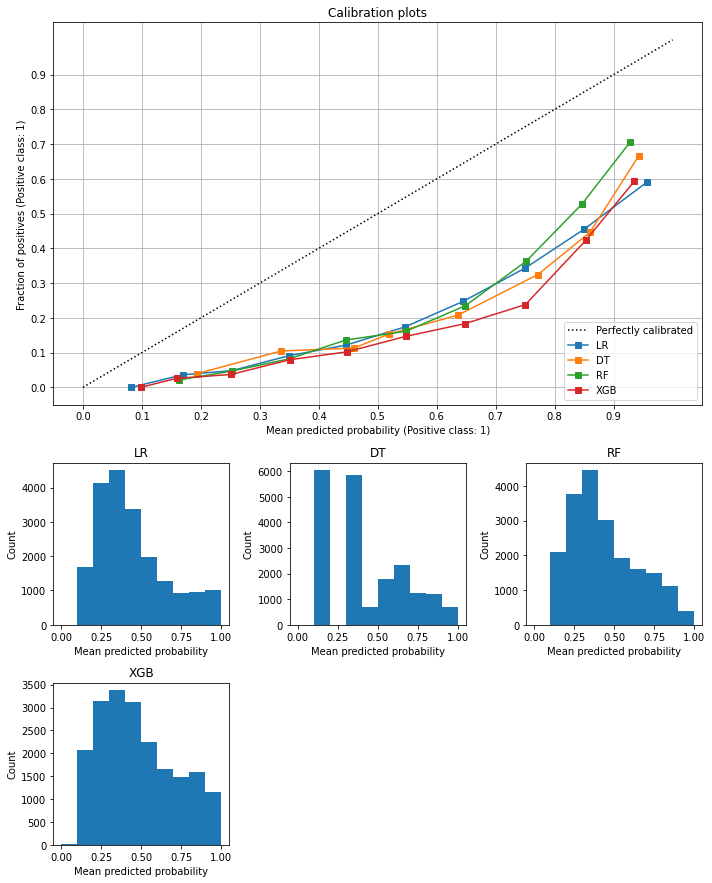

In [11]:

fig = plt.figure(figsize=(10, 15))
gs = GridSpec(5, 3)
colors = plt.cm.get_cmap("Paired")

ax_calibration_curve = fig.add_subplot(gs[:2, :3])
calibration_displays = {}
for model_name in model_names:
    model = pickle.load(open('../MODELS/TestResult/outcome_12months_'+model_name+'.sav', 'rb'))
    display = CalibrationDisplay.from_estimator(
        model,
        X_externalVal,
        y_externalVal,
        n_bins=10,
        name=model_name,
        ax=ax_calibration_curve,
        # color=colors(i),
    )
    calibration_displays[model_name] = display

ax_calibration_curve.grid()
plt.xticks(np.arange(0, 1, step=.1))
plt.yticks(np.arange(0, 1, step=.1))
ax_calibration_curve.set_title("Calibration plots")

grid_positions = [(2, 0), (2, 1),(2, 2),(3,0),(3,1),(3,2),(4,0),(4,1),(4,2) ]
i = 0
for model_name in model_names:
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[model_name].y_prob,
        range=(0, 1),
        bins=10,
        label=model_name,
        # color=colors(i),
    )
    ax.set(title=model_name, xlabel="Mean predicted probability", ylabel="Count")
    i+=1

plt.tight_layout()
plt.show()



In [21]:
model_names

['LR', 'DT', 'RF', 'XGB']

[10:12:46] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 3
[10:12:46] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:822: [GPU Hist]: Configure


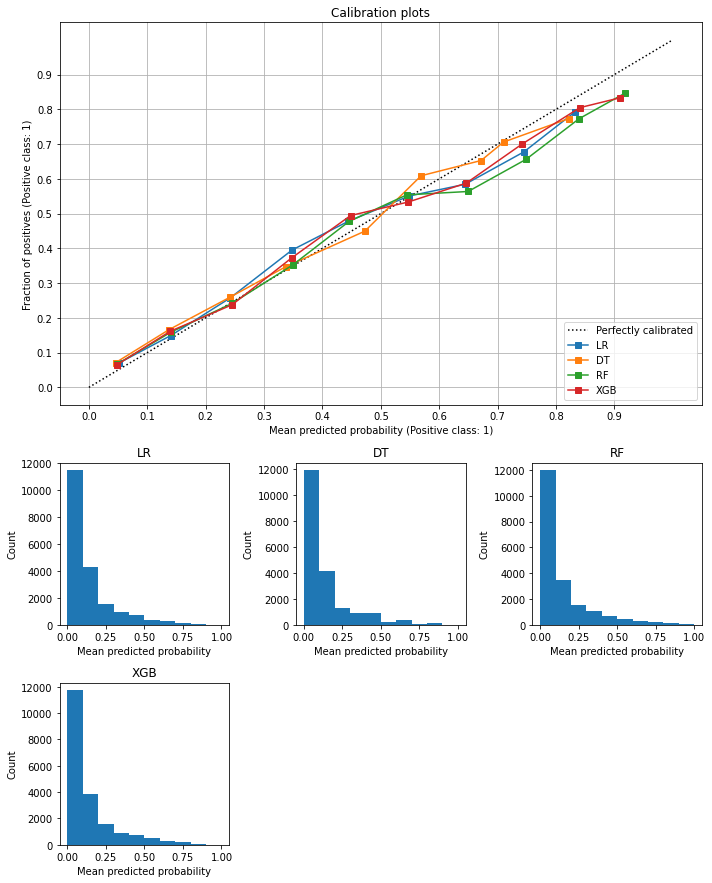

In [24]:
fig = plt.figure(figsize=(10, 15))
gs = GridSpec(5, 3)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :3])
calibration_displays = {}
model_names = [
    'LR', 
    'DT', 'RF', 
               'XGB']
for model_name in model_names:
    model = pickle.load(open('../MODELS/TestResult/outcome_12months_'+model_name+'.sav', 'rb'))
    preds = model.predict_proba(X)[:,1]
    preds_eval = model.predict_proba(X_externalVal)[:,1]
    
    # calibration method fit
    calib = mli.SplineCalib()
    calib.fit(preds, y)
    preds_spline = calib.predict_proba(preds_eval)
    display = CalibrationDisplay.from_predictions(
        y_externalVal,
        preds_spline,
        n_bins=10,
        name=model_name,
        ax=ax_calibration_curve,
        # color=colors(i),
    )
    calibration_displays[model_name] = display
    pickle.dump(calib, open('../MODELS/Calibrated/outcome_12months_'+model_name+'.sav', 'wb'))

ax_calibration_curve.grid()
plt.xticks(np.arange(0, 1, step=.1))
plt.yticks(np.arange(0, 1, step=.1))
ax_calibration_curve.set_title("Calibration plots")

grid_positions = [(2, 0), (2, 1),(2, 2),(3,0),(3,1),(3,2),(4,0),(4,1),(4,2) ]
i = 0
for model_name in model_names:
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[model_name].y_prob,
        range=(0, 1),
        bins=10,
        label=model_name,
        # color=colors(i),
    )
    ax.set(title=model_name, xlabel="Mean predicted probability", ylabel="Count")
    i+=1

plt.tight_layout()
plt.show()



In [52]:
model = pickle.load(open('../MODELS/TestResult/outcome_12months_XGB.sav', 'rb'))
calibrated_model = pickle.load(open('../MODELS/Calibrated/outcome_12months_XGB.sav', 'rb'))

In [48]:
confusion_matrix(y_externalVal, preds)

array([[16329,   436],
       [ 2446,   649]])

In [50]:
confusion_matrix(y_externalVal, preds_uncalibrated)

array([[10977,  5788],
       [  757,  2338]])

## MODEL CALIBRATION ONLY XGB

[22:31:58] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0


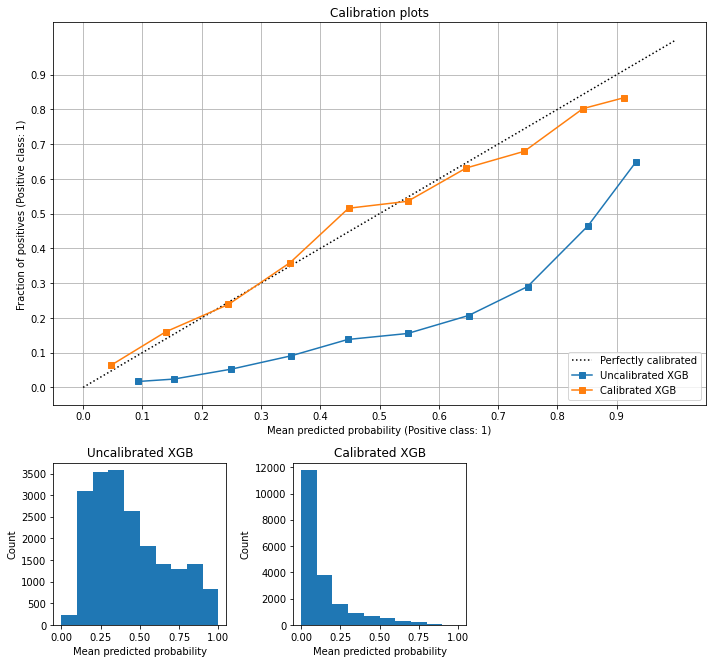

In [28]:
fig = plt.figure(figsize=(10, 15))
gs = GridSpec(5, 3)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :3])
calibration_displays = {}
model_names = [
    # 'LR', 
    # 'DT', 'RF', 
               'XGB']
for model_name in model_names:
    model = pickle.load(open('../../MODELS/TestResultOrdinal/outcome_12months_'+model_name+'.sav', 'rb'))
    preds = model.predict_proba(X)[:,1]
    preds_eval = model.predict_proba(X_externalVal)[:,1]
    
    display = CalibrationDisplay.from_estimator(
        model,
        X_externalVal,
        y_externalVal,
        n_bins=10,
        name='Uncalibrated ' + model_name,
        ax=ax_calibration_curve,
        # color=colors(i),
    )
    calibration_displays['Uncalibrated ' + model_name] = display
    
    # calibration method fit
    calib = mli.SplineCalib()
    calib.fit(preds, y)
    preds_spline = calib.predict_proba(preds_eval)
    display = CalibrationDisplay.from_predictions(
        y_externalVal,
        preds_spline,
        n_bins=10,
        name='Calibrated ' + model_name,
        ax=ax_calibration_curve,
        # color=colors(i),
    )
    calibration_displays['Calibrated ' + model_name] = display
    pickle.dump(calib, open('../../MODELS/Calibrated/ordinal_outcome_12months_'+model_name+'.sav', 'wb'))

ax_calibration_curve.grid()
plt.xticks(np.arange(0, 1, step=.1))
plt.yticks(np.arange(0, 1, step=.1))
ax_calibration_curve.set_title("Calibration plots")

grid_positions = [(2, 0), (2, 1),(2, 2),(3,0),(3,1),(3,2),(4,0),(4,1),(4,2) ]
i = 0

model_names = ['Uncalibrated XGB', 'Calibrated XGB']
for model_name in model_names:
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[model_name].y_prob,
        range=(0, 1),
        bins=10,
        label=model_name,
        # color=colors(i),
    )
    ax.set(title=model_name, xlabel="Mean predicted probability", ylabel="Count")
    i+=1

plt.tight_layout()
plt.show()



# END

In [ ]:
model_names = ['LR', 'Lasso', 'Elastics', 'DT', 'RF', 'XGB']
for model_name in model_names:
    print(model_name)
    model = pickle.load(open('../Models_trainValEval/12months/'+model_name+'0_2vs1.sav', 'rb'))
    preds = model.predict_proba(X_eval)[:,1]
    # preds = [x[1] for x in preds]
    plt.figure(figsize=(10, 5))
    mli.plot_reliability_diagram(y_eval, preds, bins=[0.  , 0.1 , 0.2 , 0.3 ,  0.4 ,  0.5 ,
        0.6 ,  0.7 ,  0.8 , 0.9 ,  1.  ])
    plt.xticks(np.arange(0, 1, step=.1))
    plt.yticks(np.arange(0, 1, step=.1))
    plt.show()
    # plt.title(model_name)
    # prob_true, prob_pred = calibration_curve(y_eval.values, preds, n_bins=10)
    # print(model_name, bin_total(y_eval.values, preds, n_bins=10))

# plt.legend(loc=4)


In [ ]:
calib1 = mli.SplineCalib()
preds_cset = model.predict_proba(X_eval)[:,1]
calib1.fit(preds_cset, y_eval)
preds_test_calib1 = calib1.calibrate(preds_cset)
mli.plot_reliability_diagram(y_eval, preds_test_calib1)
# calib1.show_calibration_curve()

In [ ]:

log_loss(y_eval, preds_cset),log_loss(y_eval, preds_test_calib1)

In [ ]:
model_names = ['LR', 'Lasso', 'Elastics', 'DT', 'RF', 'XGB']
for model_name in model_names:
    model = pickle.load(open('../Models_trainValEval/12months/'+model_name+'0_2vs1.sav', 'rb'))
    calibrated_clf = CalibratedClassifierCV(model, cv="prefit", method='isotonic')
    calibrated_clf.fit(X_eval, y_eval)
    preds = calibrated_clf.predict_proba(X_eval)
    preds = [x[1] for x in preds]
    mli.plot_reliability_diagram(y_test, preds_test_uncalib, marker='.')
    # prob_true, prob_pred = calibration_curve(y_eval.values, preds, n_bins=10)
    # print(model_name, bin_total(y_eval.values, preds, n_bins=10))

# plt.legend(loc=4)


In [ ]:
def bin_total(y_true, y_prob, n_bins):
    bins = np.linspace(0., 1. + 1e-8, n_bins + 1)

    # In sklearn.calibration.calibration_curve,
    # the last value in the array is always 0.
    binids = np.digitize(y_prob, bins) - 1

    return np.bincount(binids, minlength=len(bins))


model_names = ['LR', 'Lasso', 'Elastics', 'DT', 'RF', 'XGB']
for model_name in model_names:
    model = pickle.load(open('../Models_trainValEval/12months/'+model_name+'0_2vs1.sav', 'rb'))
    calibrated_clf = CalibratedClassifierCV(model, cv="prefit", method='isotonic')
    calibrated_clf.fit(X_eval, y_eval)
    preds = calibrated_clf.predict_proba(X_eval)
    preds = [x[1] for x in preds]
    prob_true, prob_pred = calibration_curve(y_eval.values, preds, n_bins=10)
    print(model_name, bin_total(y_eval.values, preds, n_bins=10))

# plt.legend(loc=4)


In [ ]:
X_eval.shape

In [ ]:

model_names = ['LR', 'Lasso', 'Elastics', 'DT', 'RF', 'XGB']
fig = plt.figure(figsize=(10, 15))
gs = GridSpec(5, 3)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :3])
calibration_displays = {}
for model_name in model_names:
    model = pickle.load(open('../Models_trainValEval/12months/'+model_name+'0_2vs1.sav', 'rb'))
    calibrated_clf = CalibratedClassifierCV(model, cv="prefit", method='sigmoid')
    calibrated_clf.fit(X_eval, y_eval)
    display = CalibrationDisplay.from_estimator(
        calibrated_clf,
        X_eval,
        y_eval,
        n_bins=10,
        name=model_name,
        ax=ax_calibration_curve,
        # color=colors(i),
    )
    calibration_displays[model_name] = display

ax_calibration_curve.grid()
plt.xticks(np.arange(0, 1, step=.1))
plt.yticks(np.arange(0, 1, step=.1))
ax_calibration_curve.set_title("Calibration plots")

grid_positions = [(2, 0), (2, 1),(2, 2),(3,0),(3,1),(3,2),(4,0),(4,1),(4,2) ]
i = 0
for model_name in model_names:
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[model_name].y_prob,
        range=(0, 1),
        bins=10,
        label=model_name,
        # color=colors(i),
    )
    ax.set(title=model_name, xlabel="Mean predicted probability", ylabel="Count")
    i+=1

plt.tight_layout()
plt.show()

In [ ]:

model_names = ['LR', 'Lasso', 'Elastics', 'DT', 'RF', 'XGB']
fig = plt.figure(figsize=(10, 15))
gs = GridSpec(5, 3)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :3])
calibration_displays = {}
for model_name in model_names:
    model = pickle.load(open('../Models_trainValEval/12months/'+model_name+'0_2vs1.sav', 'rb'))
    calib = mli.SplineCalib()
    preds_cset = rfmodel1.predict_proba(X_internaleval)[:,1]
    calib.fit(preds_cset, y_internaleval)
    calibrated_clf.fit(X_eval, y_eval)
    display = CalibrationDisplay.from_estimator(
        calibrated_clf,
        X_eval,
        y_eval,
        n_bins=10,
        name=model_name,
        ax=ax_calibration_curve,
        # color=colors(i),
    )
    calibration_displays[model_name] = display
    calib = 

ax_calibration_curve.grid()
plt.xticks(np.arange(0, 1, step=.1))
plt.yticks(np.arange(0, 1, step=.1))
ax_calibration_curve.set_title("Calibration plots")

grid_positions = [(2, 0), (2, 1),(2, 2),(3,0),(3,1),(3,2),(4,0),(4,1),(4,2) ]
i = 0
for model_name in model_names:
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[model_name].y_prob,
        range=(0, 1),
        bins=10,
        label=model_name,
        # color=colors(i),
    )
    ax.set(title=model_name, xlabel="Mean predicted probability", ylabel="Count")
    i+=1

plt.tight_layout()
plt.show()

In [ ]:
pred_cal = calibrated_clf.predict_proba(X_eval)
pred_noncal = model.predict_proba(X_eval)

In [ ]:
confusion_matrix(y_eval, pred_cal)

In [ ]:
confusion_matrix(y_eval, pred_noncal)

In [ ]:
from sklearn.metrics import log_loss
log_loss(y_eval, pred_noncal)

In [ ]:
y_eval.value_counts()[0]/y_eval.value_counts()[1]

In [ ]:
log_loss(y_eval, pred_cal)

In [ ]:
a = pd.DataFrame([y_eval.values, pred_noncal, pred_cal]).T
a.tail(10)

In [ ]:
def summariseResultCalibration (testX, testY, model, threshold):
    preds = model.predict_proba(testX)
    preds = [0 if x[1] < threshold else 1 for x in preds]
    tn, fp, fn, tp = confusion_matrix(testY, preds).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    ppv = 100*tp/(tp+fp)
    npv = 100*tn/(fn+tn)
    acc = accuracy_score(testY, preds)
    f1score = f1_score(testY, preds, average = 'binary')
    balanceacc = balanced_accuracy_score(testY, preds)
    aucscore = roc_auc_score(testY, preds)
    return np.round(acc,4), np.round(specificity,4), np.round(sensitivity,4), np.round(balanceacc,4), np.round(f1score,4), np.round(ppv,4), np.round(npv,4), np.round(aucscore,4)



for model_name in model_names:
    model = pickle.load(open('../Models_trainValEval/12months/'+model_name+'0_2vs1.sav', 'rb'))
    calibrated_clf = CalibratedClassifierCV(model, cv="prefit", method='isotonic')
    calibrated_clf.fit(X_eval, y_eval)
    preds = calibrated_clf.predict_proba(X_eval)
    preds = [x[1] for x in preds]
    fpr, tpr, thresholds = roc_curve(y_eval, preds)
    optimal_idx = np.argmax(tpr - fpr)# Find optimal probability threshold
    threshold = thresholds[optimal_idx]
    # calibrationResult.append(((outcome, model_name, threshold)+summariseResultCalibration(X_eval, y_eval, model, threshold)))
    aucscore = roc_auc_score(y_eval, preds)
    auprc = average_precision_score(y_eval, preds)
    print(aucscore, auprc)
    print (model_name, threshold, summariseResultCalibration(X_eval, y_eval, calibrated_clf, threshold))
    

In [ ]:
def summariseResultCalibration (testX, testY, model, threshold):
    preds = model.predict_proba(testX)
    preds = [0 if x[1] < threshold else 1 for x in preds]
    tn, fp, fn, tp = confusion_matrix(testY, preds).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    ppv = 100*tp/(tp+fp)
    npv = 100*tn/(fn+tn)
    acc = accuracy_score(testY, preds)
    f1score = f1_score(testY, preds, average = 'binary')
    balanceacc = balanced_accuracy_score(testY, preds)
    aucscore = roc_auc_score(testY, preds)
    return np.round(acc,4), np.round(specificity,4), np.round(sensitivity,4), np.round(balanceacc,4), np.round(f1score,4), np.round(ppv,4), np.round(npv,4), np.round(aucscore,4)



for model_name in model_names:
    model = pickle.load(open('../Models_trainValEval/12months/'+model_name+'0_2vs1.sav', 'rb'))
    # calibrated_clf = CalibratedClassifierCV(model, cv="prefit", method='isotonic')
    # calibrated_clf.fit(X_internaleval, y_internaleval)
    preds = model.predict_proba(X_eval)
    preds = [x[1] for x in preds]
    fpr, tpr, thresholds = roc_curve(y_eval, preds)
    optimal_idx = np.argmax(tpr - fpr)# Find optimal probability threshold
    threshold = thresholds[optimal_idx]
    # calibrationResult.append(((outcome, model_name, threshold)+summariseResultCalibration(X_eval, y_eval, model, threshold)))
    aucscore = roc_auc_score(y_eval, preds)
    auprc = average_precision_score(y_eval, preds)
    print(aucscore, auprc)
    print (model_name, threshold, summariseResultCalibration(X_eval, y_eval, model, threshold))
    

In [ ]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(10, 15))
gs = GridSpec(5, 3)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :3])
calibration_displays = {}
for model_name in model_names:
    model = pickle.load(open('../Models_trainValEval/12months/'+model_name+'0.sav', 'rb'))
    display = CalibrationDisplay.from_estimator(
        model,
        X_eval,
        y_eval,
        n_bins=10,
        name=model_name,
        ax=ax_calibration_curve,
        # color=colors(i),
    )
    calibration_displays[model_name] = display


ax_calibration_curve.grid()
plt.xticks(np.arange(0, 1, step=.1))
plt.yticks(np.arange(0, 1, step=.1))
ax_calibration_curve.set_title("Calibration plots")

grid_positions = [(2, 0), (2, 1),(2, 2),(3,0),(3,1),(3,2)]
i = 0
for model_name in model_names:
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[model_name].y_prob,
        range=(0, 1),
        bins=10,
        label=model_name,
        # color=colors(i),
    )
    ax.set(title=model_name, xlabel="Mean predicted probability", ylabel="Count")
    i+=1

plt.tight_layout()
plt.show()
